This project involves building a recommendation system based on two models

1. User features similarity (i.e if a user has a similar features like skin type, tone, eye color, hair color with another user, then probably th ey might enjoy same products)
2. Content-based recommendations (cosine similarity between the chemical compositions of the products)

Let's first start my importing all neccesary libraries

In [43]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnarDataSource, HoverTool, Select, Paragraph, TextInput
from bokeh.layouts import column, row
from ipywidgets import interact

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from matplotlib import cm

import markovify
import string

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes  import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings; warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/ama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
data = pd.read_csv('../Datasets/skindataall.csv', index_col=[0])

In [11]:
data.head(5)

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


<Axes: xlabel='Skin_Tone'>

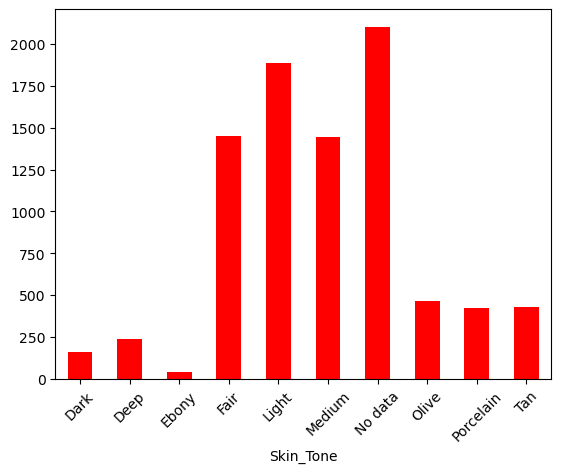

In [12]:
skintone_stats = data.groupby('Skin_Tone')['Username'].count()
skintone_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Skin_Type'>

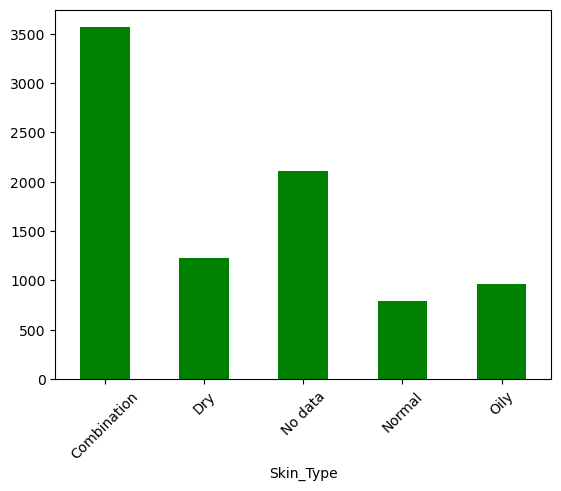

In [13]:
skintone_stats = data.groupby('Skin_Type')['Username'].count()
skintone_stats.plot.bar(color='green', rot=45)

<Axes: xlabel='Eye_Color'>

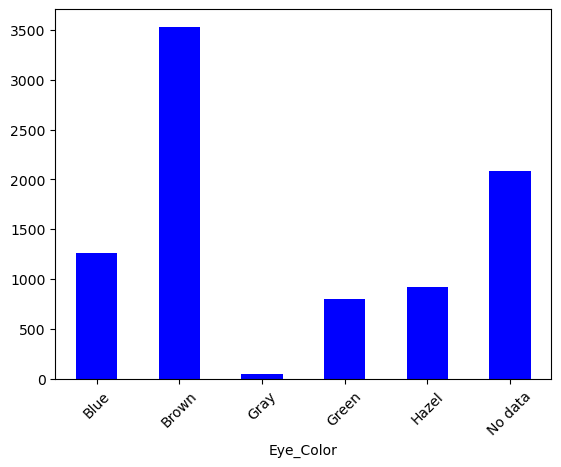

In [14]:
eyecolor_stats = data.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color='blue', rot=45)

<Axes: xlabel='Hair_Color'>

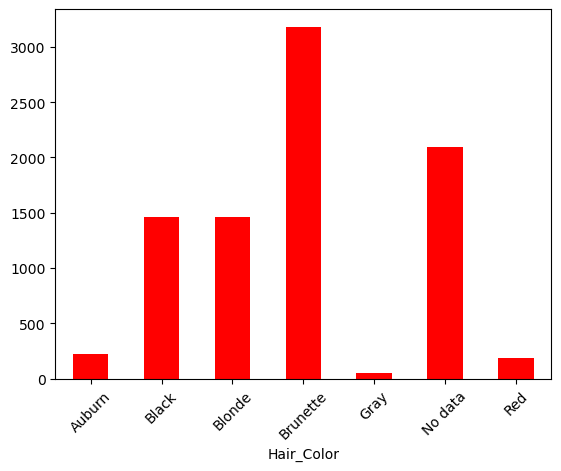

In [15]:
haircolor_stats = data.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Rating_Stars'>

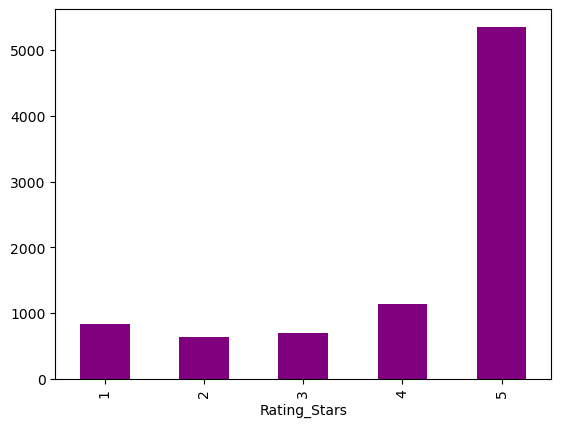

In [18]:
rating_stats = data.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color='purple')

From the graph above the ratings are unevenly distributed. We observe that the 5-star is more dorminant and with the 1 - 4 star ratings having a low frequency count. 

### Markov Chain neural net for langauge generator

In [ ]:
import markovify
import string

In [19]:
def no_punct(string):
    no_punct_string = re.sub(r'[^\w\s]', '', string)
    return no_punct_string

In [21]:
data['Review'] = data.apply(lambda row: no_punct(row['Review']), axis=1)

In [22]:
text_model = markovify.NewlineText(data.Review, state_size=2)

In [25]:
for i in range(3):
    print(text_model.make_sentence())

Evened out my already dehydrated skin without triggering my cystic acne still do not feel like the one ounce will go without it If anything it just to see positive effectsI went to waste money when theyre buying a full size based off the makeup not so bad It might be for sensitive areas of active pimples and even though after using this morning and night and occasionally daily use and said that my pores when I get through this The fact that I would definitely buy again
LOVE this I use the ordinary niacinamide have been struggling with in the hype is about it is I do use the whole product line
This cleanser removes EVERYTHING Ive been using it for 3 weeks now and I have extremely reactive sensitive acne skin for my skin feeling smooth and moisturized very well My skin is damped before application It didnt create any little rough on the rest of everything else up to two times I use this cleanser It left my skin I only purchased a different face products But after three days of purchase I

### NLP: wordclouds and classification

In [26]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [30]:
negative_data = data[data.Rating_Stars <= 4]
positive_data = data[data.Rating_Stars > 4]
negative = " ".join(review for review in negative_data.Review)
positive = " ".join(review for review in positive_data.Review)

In [27]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [28]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(data)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

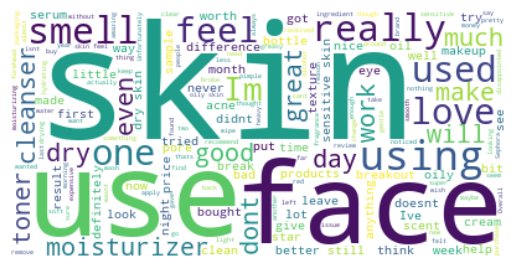

In [31]:
generate_wordcloud(negative)

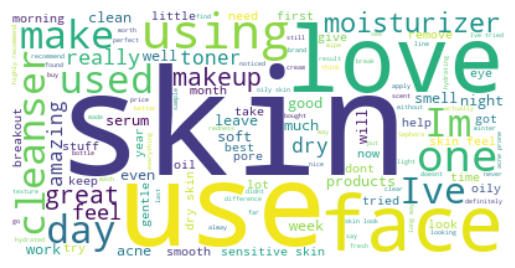

In [32]:
generate_wordcloud(positive)

Looking at wordcloud of negative reviews, you can see that a lot of people have a negative smell, complain about their face. 

We would proceed the ingredients of skincare products. Knowing very little on chemistry, let's proceed to distinguish between categories, such as serum

In [33]:
moist_data = data[data.Category == 'Moisturizer']
cleanse_data = data[data.Category == 'Cleanser']
mask_data = data[data.Category == 'Face Mask']
treat_data = data[data.Category == 'Treatment']

In [36]:
moist = ' '.join(ing for ing in moist_data.Ingredients)
cleanse = ' '.join(ing for ing in cleanse_data.Ingredients)
mask = ' '.join(ing for ing in mask_data.Ingredients)
treat = ' '.join(ing for ing in treat_data.Ingredients)

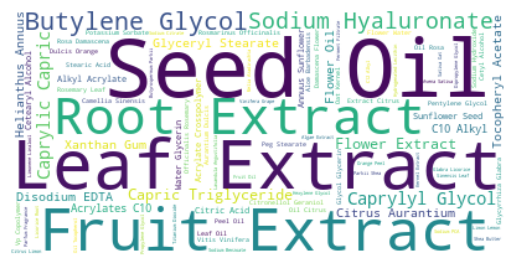

In [37]:
generate_wordcloud(moist)

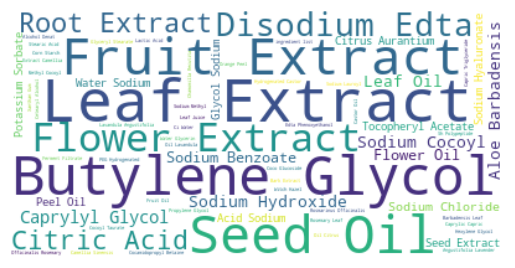

In [38]:
generate_wordcloud(cleanse)

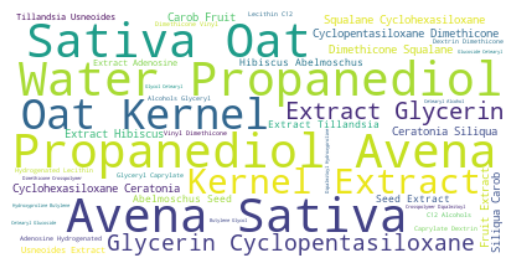

In [39]:
generate_wordcloud(mask)

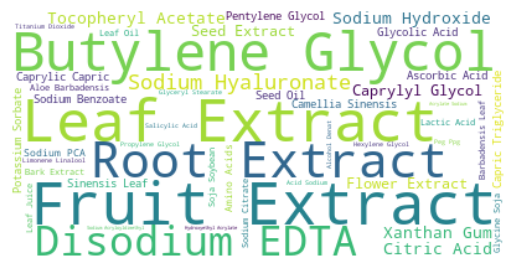

In [40]:
generate_wordcloud(treat)

We would proceed to build classification model to distinguish the products.

In [41]:
X = data.Ingredients
y = data.Category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [44]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

#### Naive Bayes

In [47]:
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### Logistic Regression

In [48]:
logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])

logreg.fit(X_train, y_train)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### SVG with SGD

In [52]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



### Latent Dirichlet Allocation

Now that w ehave different skincare categories would be distinguishable, we would proceed to do unsupervised clusstgering to figure out how the ingredients would group naturally.

In [74]:
from __future__ import print_function
import pyLDAvis
#import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [55]:
ing_raw = data.Ingredients

In [57]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(ing_raw)

In [58]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(ing_raw)

In [59]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=4, random_state=0)

### Quality and effectiveness check